In [35]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

from sklearn.datasets import fetch_20newsgroups

import nltk, string, itertools, time
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, v_measure_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from scipy.optimize import linear_sum_assignment
from umap import UMAP

In [5]:
# Custom stop words
stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(stop_words_skt))

In [27]:
def plot_contingency_table_20(cm, title='Contingency Table', cmap=plt.cm.YlOrBr):
    plt.gcf().clear()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    tick_marks = np.arange(20)
    number_labels = [x for x in range(1,21)]
    plt.xticks(tick_marks, number_labels)
    plt.yticks(tick_marks, number_labels)
    
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)
    plt.gcf().set_size_inches(10.0,10.0)
    plt.show()

In [28]:
def k_means_clustering(training_data,
                       target_labels,
                       title='Contingency Matrix',
                       n_clusters=20,
                       random_state=0,
                       max_iter=1000,
                       n_init=30):
    start = time.time()
    km = KMeans(n_clusters=n_clusters,random_state=random_state,max_iter=max_iter,n_init=n_init)
    km.fit(training_data)
    print("Finished clustering in %f seconds" % (time.time()-start))

    cm = contingency_matrix(target_labels, km.labels_)
    # reorder to maximize along diagonal
    rows, cols = linear_sum_assignment(cm, maximize=True)
    new_cm = cm[rows[:,np.newaxis], cols]
    
    print("Show Contingency Matrix:")
    plot_contingency_table_20(new_cm, title=title)
    
    print("Report 5 Measures for K-Means Clustering")
    
    homogeneity = homogeneity_score(target_labels, km.labels_)
    completeness = completeness_score(target_labels, km.labels_)
    v_measure = v_measure_score(target_labels, km.labels_)
    adjusted_rand_index = adjusted_rand_score(target_labels, km.labels_)
    adjusted_mutual_info = adjusted_mutual_info_score(target_labels, km.labels_)

    print("Homogeneity Score: %f" % homogeneity)
    print("Completeness Score: %f" % completeness)
    print("V-Measure Score: %f" % v_measure)
    print("Adjusted Rand Index: %f" % adjusted_rand_index)
    print("Adjusted Mutual Information: %f" % adjusted_mutual_info)
    
    results = {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }
    
    return results, km

In [33]:
def plot_histogram(title_name, ydata, x_labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300'], 
                   height=range(1,10),xtickangle=0):
    plt.gcf().clear()
    fig, ax = plt.subplots()
    ax.set_xticks([i+0.25 for i in height])
    ax.set_xticklabels(x_labels, fontsize = 12)
    
    rects = plt.bar([i for i in height], ydata, 0.5, align='edge', alpha = 0.8)
    plt.xlabel('Number of Principal Components r', fontsize = 14)
    plt.ylabel('Measure Score', fontsize = 14)
    plt.title(title_name, fontsize = 18)
    plt.axis([0.5,len(x_labels)+1,0,1])
    
    plt.xticks(rotation=xtickangle)
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%.3f' % float(height), ha='center', va='bottom')
    
    plt.show()

In [31]:
def nmf_dimension_reduction(training_data, n_components=None, solver='cd', beta_loss='frobenius', max_iter=1000, random_state=0):
    start = time.time()
    nmf = NMF(n_components=n_components, solver=solver, init='nndsvda', beta_loss=beta_loss, max_iter=max_iter, random_state=random_state)
    nmf_dataset = nmf.fit_transform(training_data)
    print("NMF complete after %f seconds" % (time.time()-start))
    return nmf_dataset, nmf

In [101]:
def umap_dimension_reduction(training_data, n_components=20, metric='cosine', disconnection_distance=None, random_state=0):
    start = time.time()
    umap = UMAP(n_components=n_components, metric=metric, disconnection_distance=disconnection_distance, random_state=random_state)
    umap_dataset = umap.fit_transform(training_data)
    print("UMAP complete after %f seconds" % (time.time()-start))
    return umap_dataset, umap

In [8]:
#Question 9
dataset_20 = fetch_20newsgroups(subset='all',shuffle=True, remove=('headers', 'footers'), random_state=42)
tfidf_vect_20 = TfidfVectorizer(stop_words=combined_stopwords,min_df=3)
X_train_tfidf_20 = tfidf_vect_20.fit_transform(dataset_20.data) # making the tfidf matrix
print(X_train_tfidf_20.shape)

y_true_20 = dataset_20.target

km_20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
y_pred_20 = km_20.fit_predict(TruncatedSVD(n_components=50,random_state=0).fit_transform(X_train_tfidf_20))
con_mat_20 = contingency_matrix(y_true_20,y_pred_20)
print("Contingency table: ")
print(con_mat_20)

print("Homogeneity score for the whole corpus: ", homogeneity_score(y_true_20,y_pred_20))
print("Completeness score for the whole corpus: ",completeness_score(y_true_20,y_pred_20))
print("V-measure score for the whole corpus: ",v_measure_score(y_true_20,y_pred_20))
print("Adjusted Rand score for the whole corpus: ",adjusted_rand_score(y_true_20,y_pred_20))
print("Adjusted mutual information score for the whole corpus: ",adjusted_mutual_info_score(y_true_20,y_pred_20))

(18846, 45338)
Contingency table: 
[[193 100 101 282   0   1   2   0  99   3   0   0   0   1   2   1   1   0
   13   0]
 [ 62 298   0   1  35   1   9   4  35 157   0   0   0 307   0   0   0  64
    0   0]
 [ 64 181   0   1 414   0   0   0  26  70   0  16   0 119   0   0   0  94
    0   0]
 [ 44 288   0   0  49   3   4   1  42 117   3 203   0  19   2   0   0 207
    0   0]
 [113 439   0   0   8   2   4   1  34 133   0 104   0  13   0   0   0 111
    0   1]
 [ 42 216   0   0  57   7   3   6  24 109   0   1   0 514   0   0   0   9
    0   0]
 [ 43 596   0   0  19   0   0  70  22  68  17  56   0   5  28   0   0  51
    0   0]
 [142 266   0   1   2   0   1   2 128  37   0   2   0   2 396   0   0   0
   11   0]
 [191 449   0   0   0   0   1   0 281  32   2   6   0   1  32   0   0   0
    0   1]
 [201 228   0   2   0   0   1   3  85  46 120   0   0   1   0   0   0   0
    0 307]
 [ 80 118   0   2   0   0   1   9  21  18 231   0   0   0   0   0   0   0
    0 519]
 [101 203   0   0   8 451   4 

In [10]:
# reorder to maximize along diagonal
cm = confusion_matrix(y_true_20, y_pred_20)
rows, cols = linear_sum_assignment(cm, maximize=True)
new_cm = cm[rows[:,np.newaxis], cols]

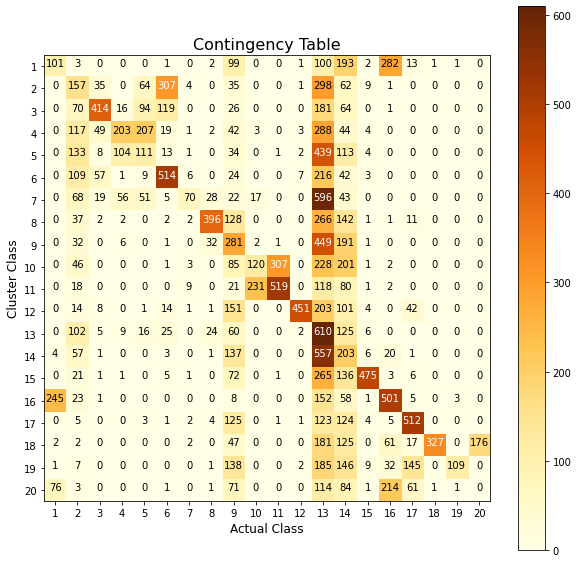

In [15]:
plot_contingency_table_20(new_cm)

n_components: 1
NMF complete after 2.637234 seconds
Finished clustering in 1.061986 seconds
Show Contingency Matrix:


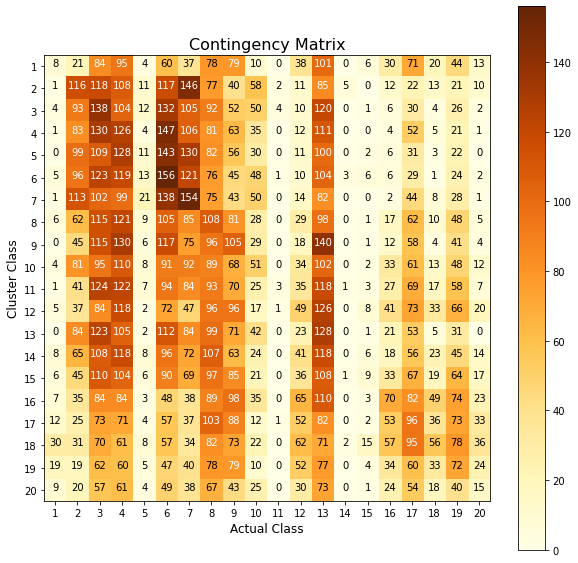

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.025393
Completeness Score: 0.028832
V-Measure Score: 0.027003
Adjusted Rand Index: 0.005504
Adjusted Mutual Information: 0.023613
n_components: 2
NMF complete after 11.365406 seconds
Finished clustering in 1.388666 seconds
Show Contingency Matrix:


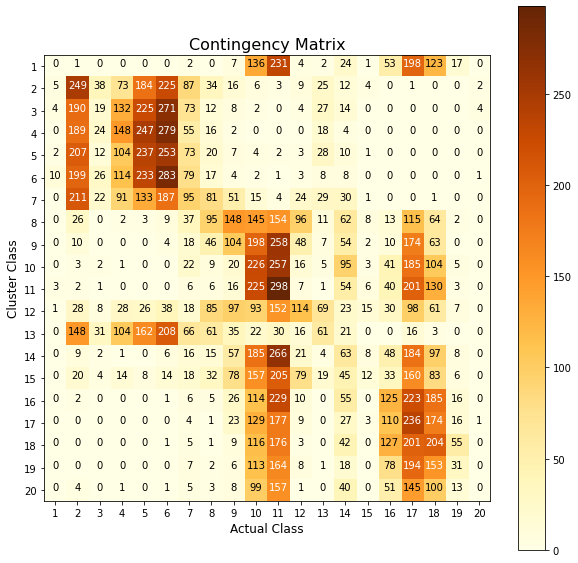

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.197520
Completeness Score: 0.225177
V-Measure Score: 0.210444
Adjusted Rand Index: 0.061763
Adjusted Mutual Information: 0.207692
n_components: 3
NMF complete after 23.034154 seconds
Finished clustering in 1.491741 seconds
Show Contingency Matrix:


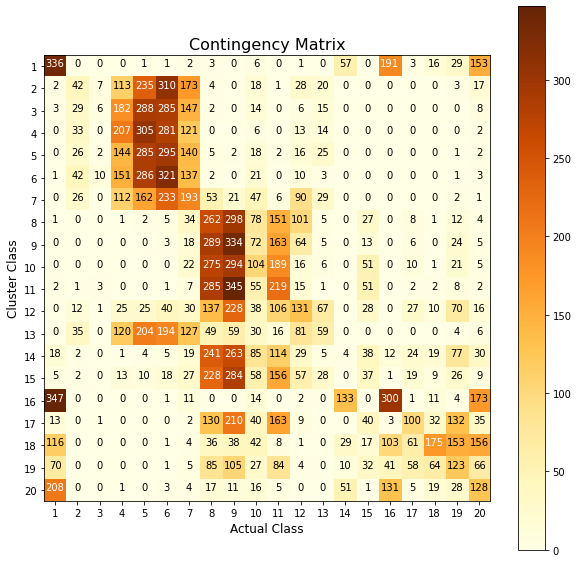

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.278874
Completeness Score: 0.305391
V-Measure Score: 0.291531
Adjusted Rand Index: 0.100421
Adjusted Mutual Information: 0.289114
n_components: 5
NMF complete after 23.546282 seconds
Finished clustering in 1.912669 seconds
Show Contingency Matrix:


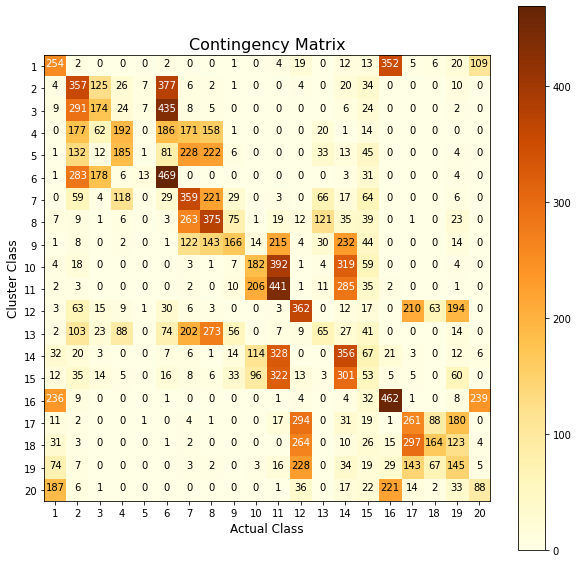

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.387035
Completeness Score: 0.408639
V-Measure Score: 0.397544
Adjusted Rand Index: 0.168810
Adjusted Mutual Information: 0.395528
n_components: 10
NMF complete after 36.511745 seconds
Finished clustering in 1.520677 seconds
Show Contingency Matrix:


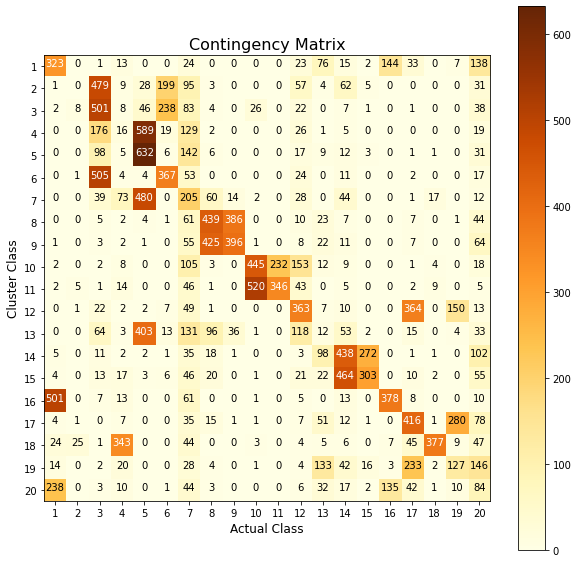

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.461592
Completeness Score: 0.483712
V-Measure Score: 0.472393
Adjusted Rand Index: 0.245988
Adjusted Mutual Information: 0.470637
n_components: 20
NMF complete after 60.758110 seconds
Finished clustering in 1.519881 seconds
Show Contingency Matrix:


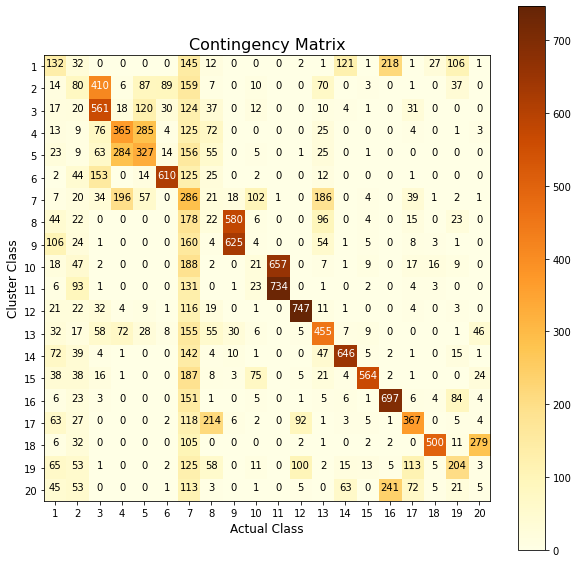

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.462230
Completeness Score: 0.484221
V-Measure Score: 0.472970
Adjusted Rand Index: 0.264474
Adjusted Mutual Information: 0.471228
n_components: 50
NMF complete after 131.409267 seconds
Finished clustering in 2.333386 seconds
Show Contingency Matrix:


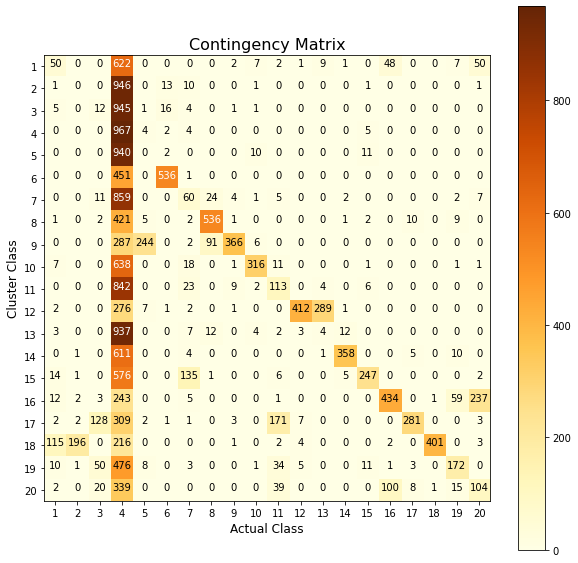

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.307625
Completeness Score: 0.533807
V-Measure Score: 0.390317
Adjusted Rand Index: 0.043475
Adjusted Mutual Information: 0.387800
n_components: 100
NMF complete after 263.677694 seconds
Finished clustering in 3.795993 seconds
Show Contingency Matrix:


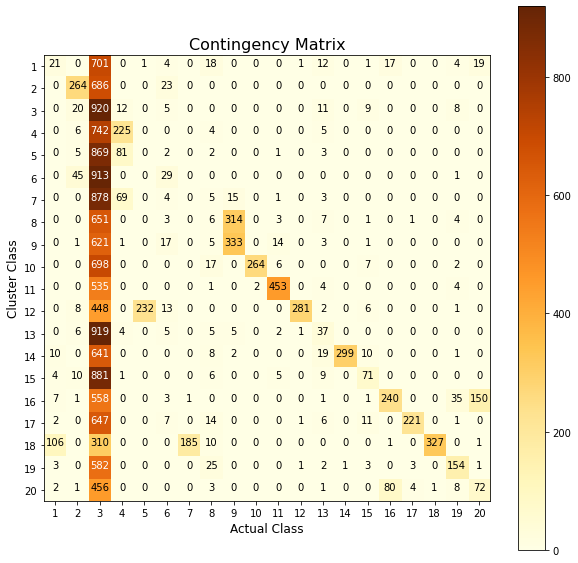

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.217950
Completeness Score: 0.476393
V-Measure Score: 0.299074
Adjusted Rand Index: 0.016701
Adjusted Mutual Information: 0.295920
n_components: 300
NMF complete after 717.007615 seconds
Finished clustering in 9.354763 seconds
Show Contingency Matrix:


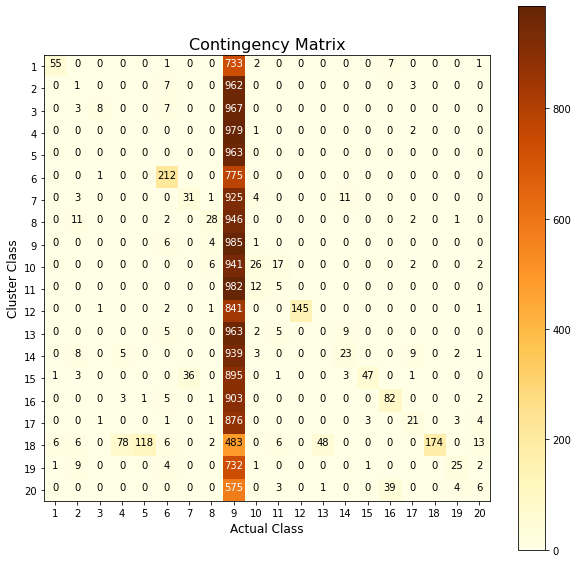

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.064358
Completeness Score: 0.394907
V-Measure Score: 0.110678
Adjusted Rand Index: 0.002443
Adjusted Mutual Information: 0.105277


In [32]:
# Question 10
nmf_kl_homogeneity_1ist = []
nmf_kl_completeness_1ist = []
nmf_kl_v_measure_1ist = []
nmf_kl_adjusted_mutual_info_1ist = []
nmf_kl_adjusted_rand_index_1ist = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    nmf_dataset, nmf = nmf_dimension_reduction(X_train_tfidf_20, n_components = r, solver='mu', beta_loss='kullback-leibler', max_iter=1000, random_state=0)
    k_means, km = k_means_clustering(nmf_dataset, y_true_20, n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    nmf_kl_homogeneity_1ist.append(k_means['homogeneity'])
    nmf_kl_completeness_1ist.append(k_means['completeness'])
    nmf_kl_v_measure_1ist.append(k_means['v_measure'])
    nmf_kl_adjusted_mutual_info_1ist.append(k_means['adjusted_mutual_info'])
    nmf_kl_adjusted_rand_index_1ist.append(k_means['adjusted_rand_index'])

<Figure size 432x288 with 0 Axes>

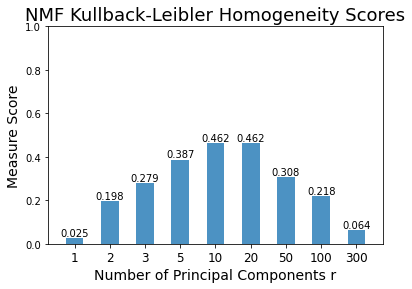

<Figure size 432x288 with 0 Axes>

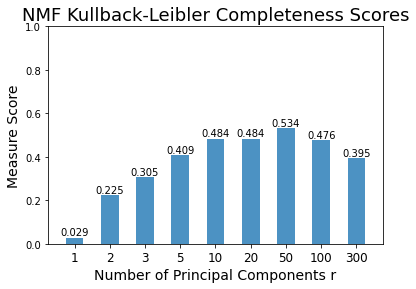

<Figure size 432x288 with 0 Axes>

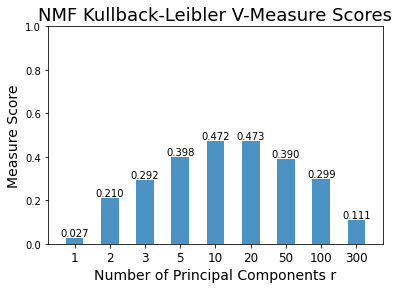

<Figure size 432x288 with 0 Axes>

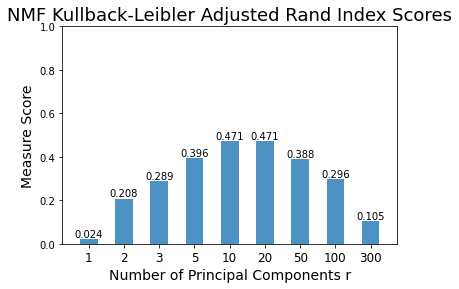

<Figure size 432x288 with 0 Axes>

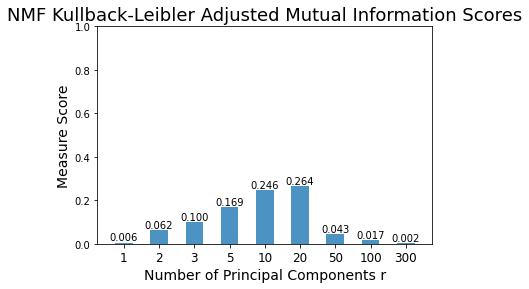

In [34]:
plot_histogram('NMF Kullback-Leibler Homogeneity Scores', nmf_kl_homogeneity_1ist)
plot_histogram('NMF Kullback-Leibler Completeness Scores', nmf_kl_completeness_1ist)
plot_histogram('NMF Kullback-Leibler V-Measure Scores', nmf_kl_v_measure_1ist)
plot_histogram('NMF Kullback-Leibler Adjusted Rand Index Scores', nmf_kl_adjusted_mutual_info_1ist)
plot_histogram('NMF Kullback-Leibler Adjusted Mutual Information Scores', nmf_kl_adjusted_rand_index_1ist)

n_components: 1
UMAP complete after 40.324218 seconds
Finished clustering in 1.313801 seconds
Show Contingency Matrix:


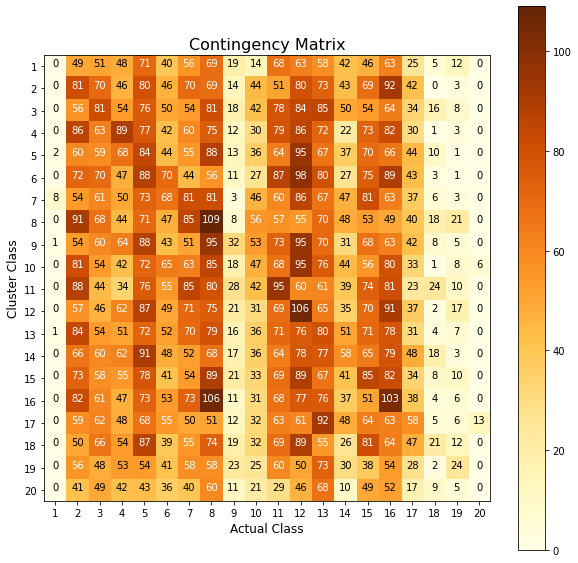

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.008532
Completeness Score: 0.009173
V-Measure Score: 0.008841
Adjusted Rand Index: 0.001001
Adjusted Mutual Information: 0.005480
n_components: 2
UMAP complete after 42.535130 seconds
Finished clustering in 1.880190 seconds
Show Contingency Matrix:


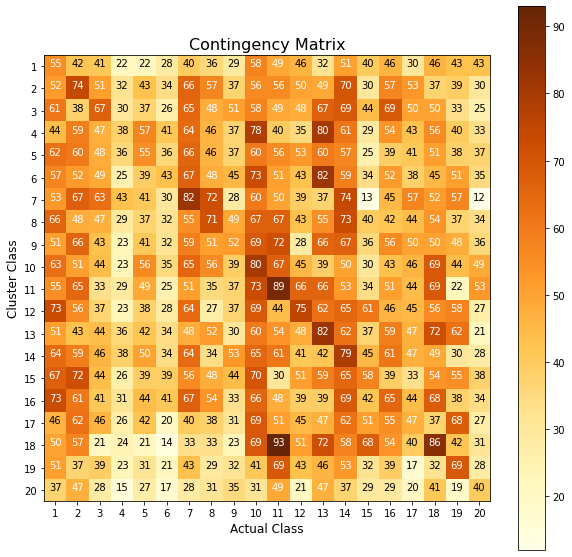

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.007765
Completeness Score: 0.007812
V-Measure Score: 0.007789
Adjusted Rand Index: 0.001373
Adjusted Mutual Information: 0.004577
n_components: 3
UMAP complete after 44.876646 seconds
Finished clustering in 2.080302 seconds
Show Contingency Matrix:


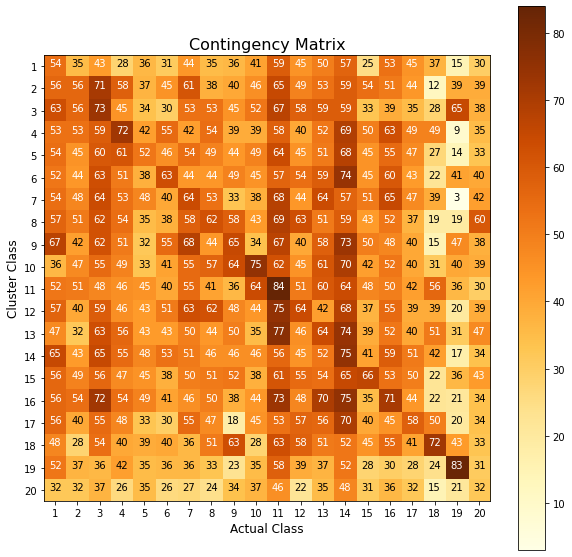

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.007013
Completeness Score: 0.007040
V-Measure Score: 0.007027
Adjusted Rand Index: 0.000901
Adjusted Mutual Information: 0.003816
n_components: 5
UMAP complete after 49.125373 seconds
Finished clustering in 2.643474 seconds
Show Contingency Matrix:


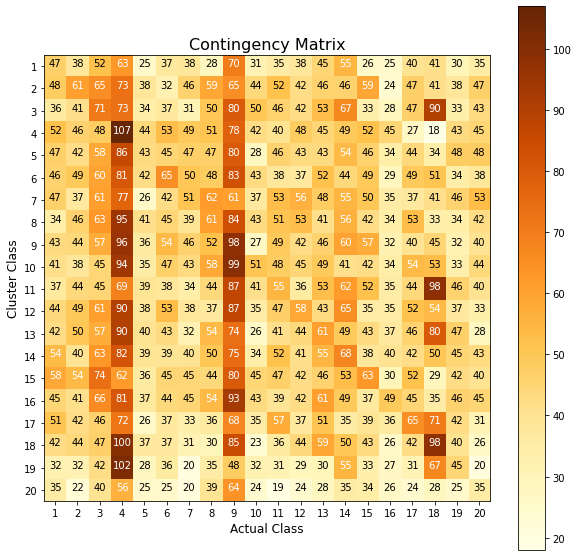

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005709
Completeness Score: 0.005758
V-Measure Score: 0.005733
Adjusted Rand Index: 0.000847
Adjusted Mutual Information: 0.002511
n_components: 10
UMAP complete after 60.774025 seconds
Finished clustering in 2.930298 seconds
Show Contingency Matrix:


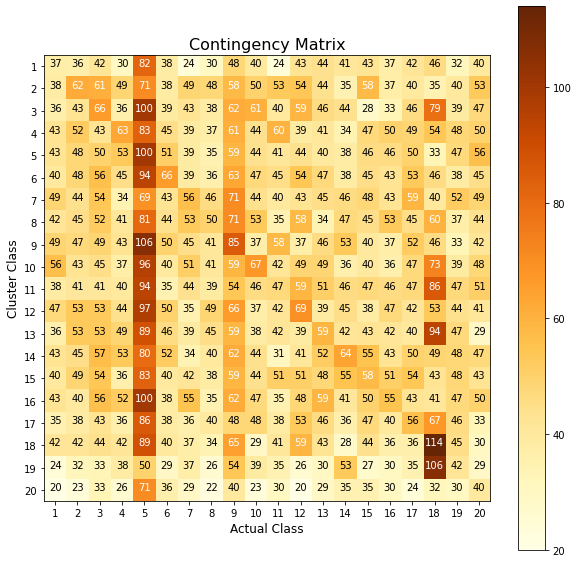

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005266
Completeness Score: 0.005294
V-Measure Score: 0.005280
Adjusted Rand Index: 0.000782
Adjusted Mutual Information: 0.002062
n_components: 20
UMAP complete after 67.887029 seconds
Finished clustering in 3.714962 seconds
Show Contingency Matrix:


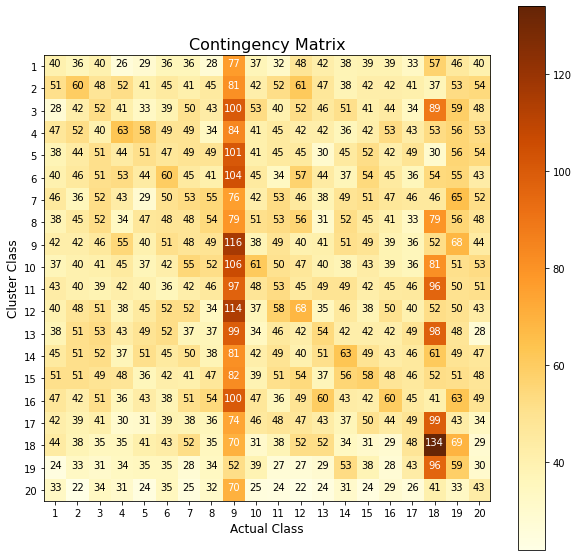

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005486
Completeness Score: 0.005519
V-Measure Score: 0.005502
Adjusted Rand Index: 0.000970
Adjusted Mutual Information: 0.002284
n_components: 50
UMAP complete after 109.694765 seconds
Finished clustering in 4.832081 seconds
Show Contingency Matrix:


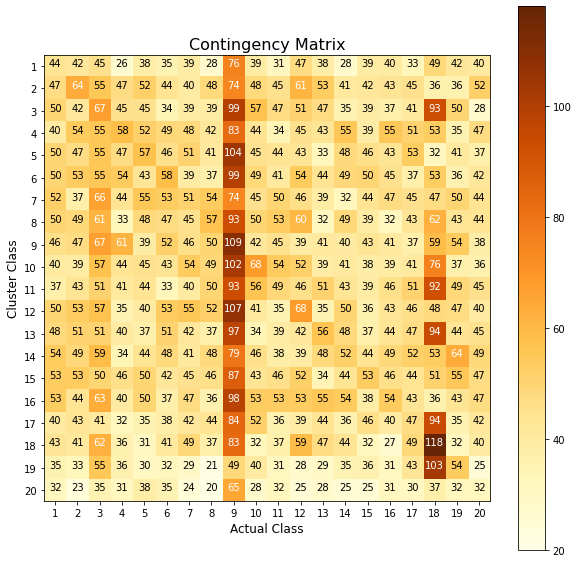

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005135
Completeness Score: 0.005164
V-Measure Score: 0.005149
Adjusted Rand Index: 0.000797
Adjusted Mutual Information: 0.001930
n_components: 100
UMAP complete after 163.757964 seconds
Finished clustering in 7.506149 seconds
Show Contingency Matrix:


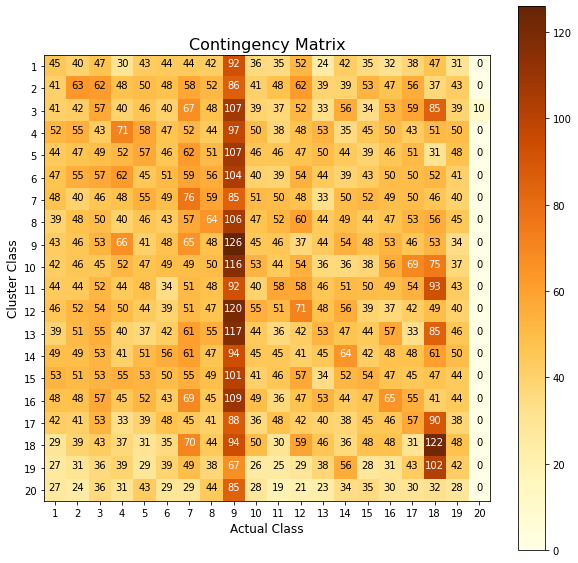

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005520
Completeness Score: 0.005654
V-Measure Score: 0.005586
Adjusted Rand Index: 0.000751
Adjusted Mutual Information: 0.002335
n_components: 300
UMAP complete after 400.132073 seconds
Finished clustering in 14.924729 seconds
Show Contingency Matrix:


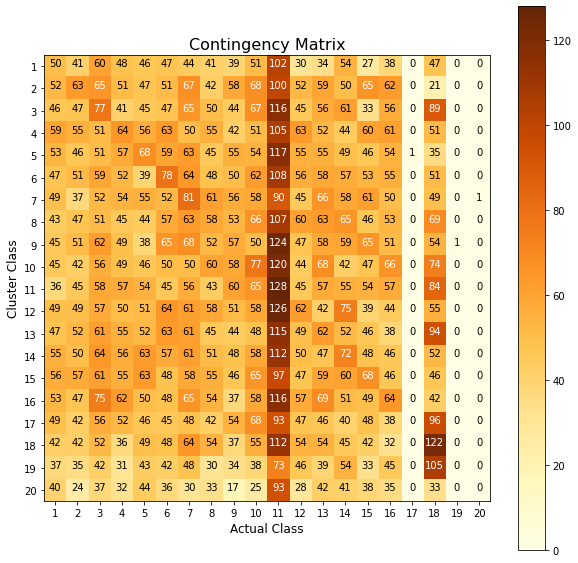

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005256
Completeness Score: 0.005596
V-Measure Score: 0.005420
Adjusted Rand Index: 0.000834
Adjusted Mutual Information: 0.002472


In [91]:
# Question 11
umap_euclidean_homogeneity_1ist = []
umap_euclidean_completeness_1ist = []
umap_euclidean_v_measure_1ist = []
umap_euclidean_adjusted_mutual_info_1ist = []
umap_euclidean_adjusted_rand_index_1ist = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    umap_dataset, umap = umap_dimension_reduction(X_train_tfidf_20, n_components = r, metric='euclidean', random_state=0)
    k_means, km = k_means_clustering(umap_dataset, y_true_20, n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    umap_euclidean_homogeneity_1ist.append(k_means['homogeneity'])
    umap_euclidean_completeness_1ist.append(k_means['completeness'])
    umap_euclidean_v_measure_1ist.append(k_means['v_measure'])
    umap_euclidean_adjusted_mutual_info_1ist.append(k_means['adjusted_mutual_info'])
    umap_euclidean_adjusted_rand_index_1ist.append(k_means['adjusted_rand_index'])

<Figure size 432x288 with 0 Axes>

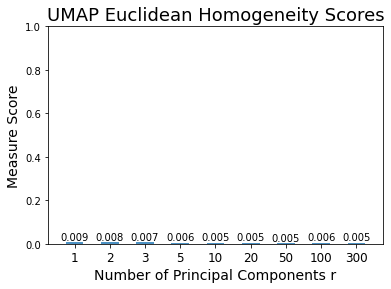

<Figure size 432x288 with 0 Axes>

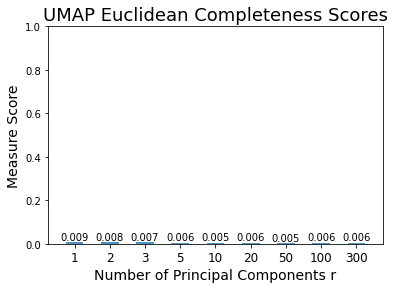

<Figure size 432x288 with 0 Axes>

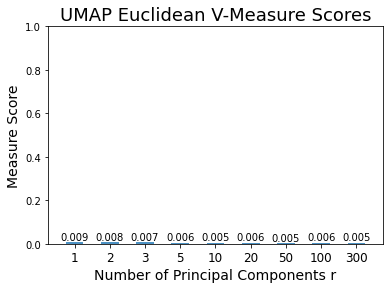

<Figure size 432x288 with 0 Axes>

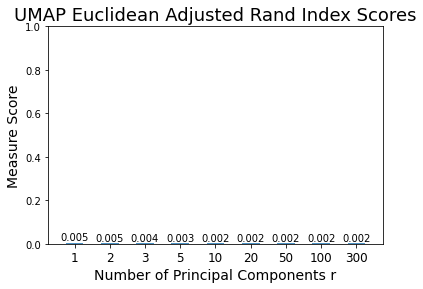

<Figure size 432x288 with 0 Axes>

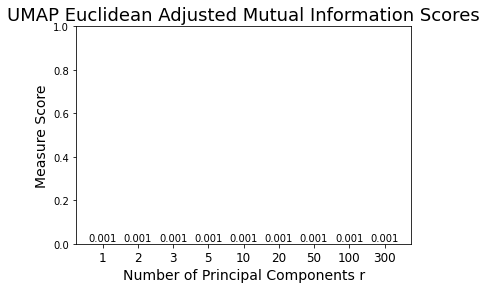

In [92]:
plot_histogram('UMAP Euclidean Homogeneity Scores', umap_euclidean_homogeneity_1ist)
plot_histogram('UMAP Euclidean Completeness Scores', umap_euclidean_completeness_1ist)
plot_histogram('UMAP Euclidean V-Measure Scores', umap_euclidean_v_measure_1ist)
plot_histogram('UMAP Euclidean Adjusted Rand Index Scores', umap_euclidean_adjusted_mutual_info_1ist)
plot_histogram('UMAP Euclidean Adjusted Mutual Information Scores', umap_euclidean_adjusted_rand_index_1ist)

n_components: 1
UMAP complete after 40.274640 seconds
Finished clustering in 1.413378 seconds
Show Contingency Matrix:


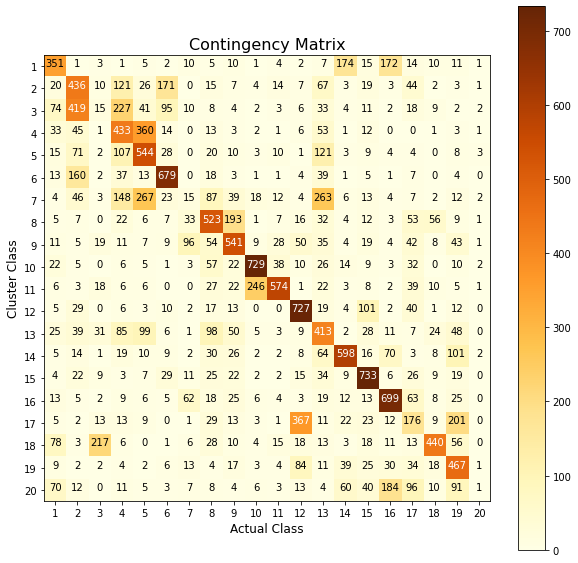

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.430314
Completeness Score: 0.445549
V-Measure Score: 0.437799
Adjusted Rand Index: 0.297585
Adjusted Mutual Information: 0.435937
n_components: 2
UMAP complete after 44.633664 seconds
Finished clustering in 1.603356 seconds
Show Contingency Matrix:


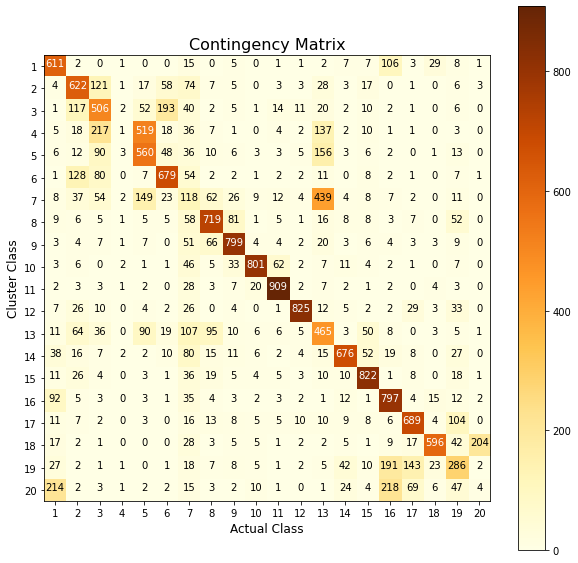

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.562357
Completeness Score: 0.578616
V-Measure Score: 0.570371
Adjusted Rand Index: 0.446195
Adjusted Mutual Information: 0.568953
n_components: 3
UMAP complete after 42.630775 seconds
Finished clustering in 2.028874 seconds
Show Contingency Matrix:


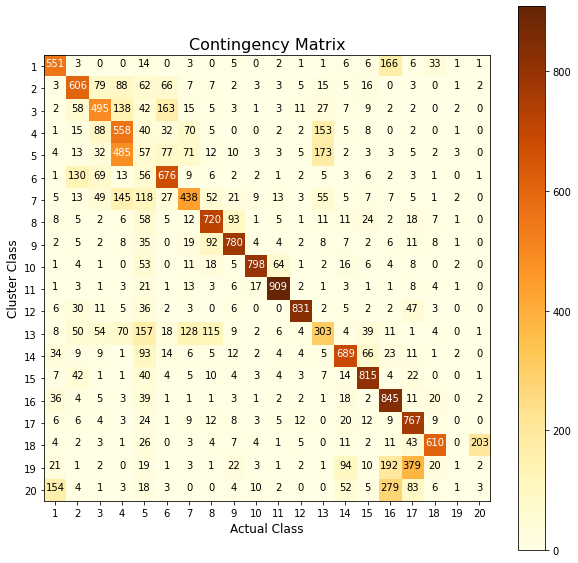

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.558873
Completeness Score: 0.576123
V-Measure Score: 0.567367
Adjusted Rand Index: 0.442089
Adjusted Mutual Information: 0.565938
n_components: 5
UMAP complete after 44.823383 seconds
Finished clustering in 1.971725 seconds
Show Contingency Matrix:


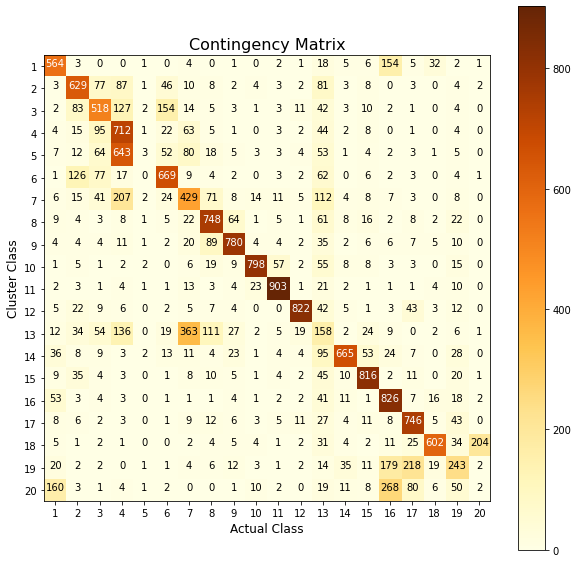

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.565223
Completeness Score: 0.585504
V-Measure Score: 0.575185
Adjusted Rand Index: 0.448447
Adjusted Mutual Information: 0.573778
n_components: 10
UMAP complete after 49.582936 seconds
Finished clustering in 2.185994 seconds
Show Contingency Matrix:


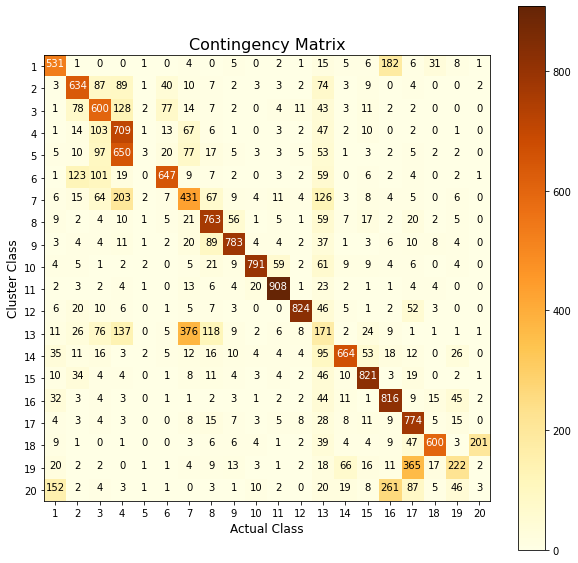

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.572315
Completeness Score: 0.594859
V-Measure Score: 0.583369
Adjusted Rand Index: 0.452950
Adjusted Mutual Information: 0.581987
n_components: 20
UMAP complete after 53.166825 seconds
Finished clustering in 2.735691 seconds
Show Contingency Matrix:


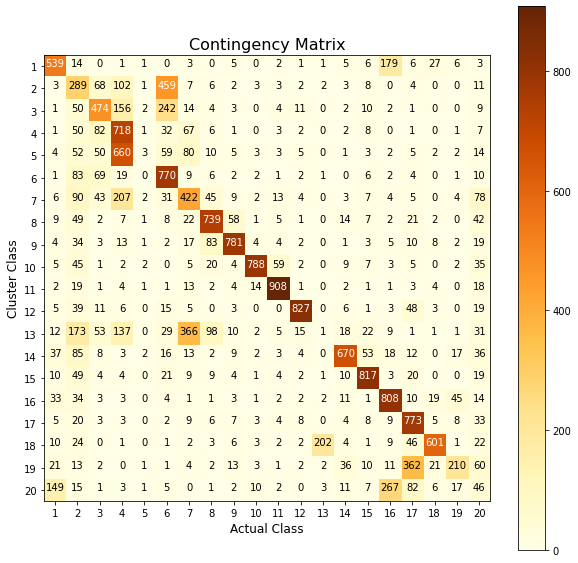

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.560304
Completeness Score: 0.587032
V-Measure Score: 0.573356
Adjusted Rand Index: 0.436063
Adjusted Mutual Information: 0.571935
n_components: 50
UMAP complete after 69.104243 seconds
Finished clustering in 4.111390 seconds
Show Contingency Matrix:


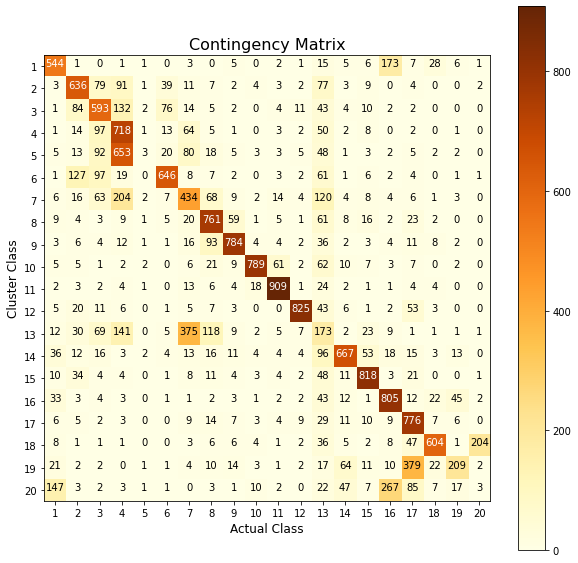

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.571971
Completeness Score: 0.595419
V-Measure Score: 0.583459
Adjusted Rand Index: 0.452224
Adjusted Mutual Information: 0.582076
n_components: 100
UMAP complete after 94.564395 seconds
Finished clustering in 5.466534 seconds
Show Contingency Matrix:


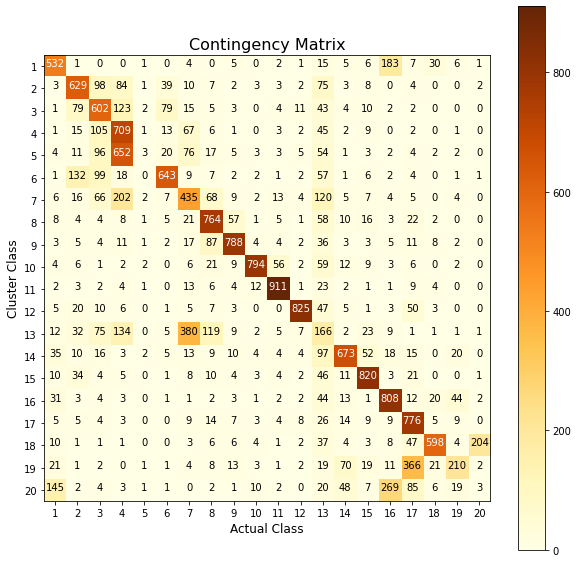

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.572130
Completeness Score: 0.595208
V-Measure Score: 0.583441
Adjusted Rand Index: 0.453238
Adjusted Mutual Information: 0.582058
n_components: 300
UMAP complete after 214.475594 seconds
Finished clustering in 14.662022 seconds
Show Contingency Matrix:


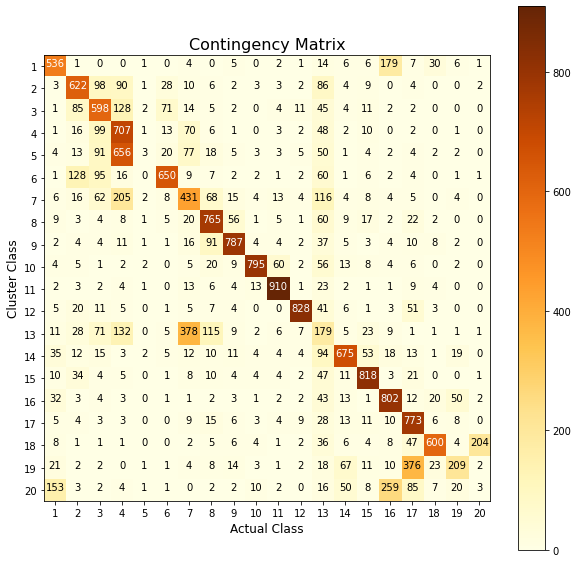

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.571842
Completeness Score: 0.594804
V-Measure Score: 0.583097
Adjusted Rand Index: 0.453070
Adjusted Mutual Information: 0.581713


In [107]:
# Question 11
umap_cosine_homogeneity_1ist = []
umap_cosine_completeness_1ist = []
umap_cosine_v_measure_1ist = []
umap_cosine_adjusted_mutual_info_1ist = []
umap_cosine_adjusted_rand_index_1ist = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    umap_dataset, umap = umap_dimension_reduction(X_train_tfidf_20, n_components=r, metric='cosine', disconnection_distance=2, random_state=0)
    k_means, km = k_means_clustering(umap_dataset, y_true_20, n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    umap_cosine_homogeneity_1ist.append(k_means['homogeneity'])
    umap_cosine_completeness_1ist.append(k_means['completeness'])
    umap_cosine_v_measure_1ist.append(k_means['v_measure'])
    umap_cosine_adjusted_mutual_info_1ist.append(k_means['adjusted_mutual_info'])
    umap_cosine_adjusted_rand_index_1ist.append(k_means['adjusted_rand_index'])

<Figure size 432x288 with 0 Axes>

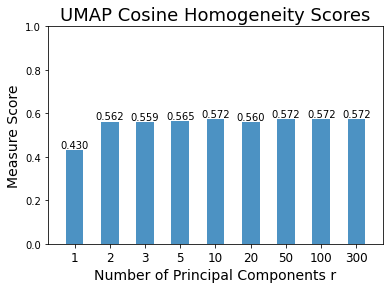

<Figure size 432x288 with 0 Axes>

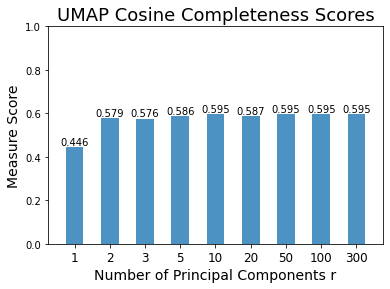

<Figure size 432x288 with 0 Axes>

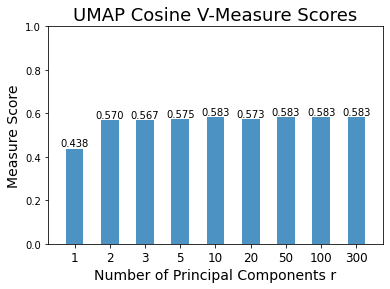

<Figure size 432x288 with 0 Axes>

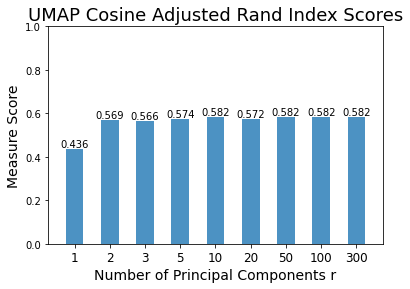

<Figure size 432x288 with 0 Axes>

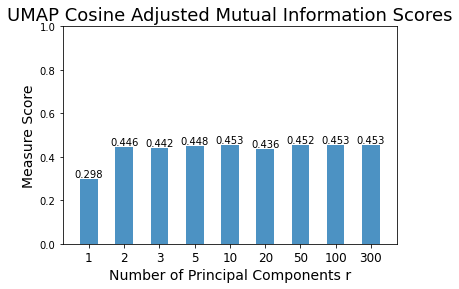

In [108]:
plot_histogram('UMAP Cosine Homogeneity Scores', umap_cosine_homogeneity_1ist)
plot_histogram('UMAP Cosine Completeness Scores', umap_cosine_completeness_1ist)
plot_histogram('UMAP Cosine V-Measure Scores', umap_cosine_v_measure_1ist)
plot_histogram('UMAP Cosine Adjusted Rand Index Scores', umap_cosine_adjusted_mutual_info_1ist)
plot_histogram('UMAP Cosine Adjusted Mutual Information Scores', umap_cosine_adjusted_rand_index_1ist)